# L-RVGA comparisson

In this notebook, we make use of the [XP_LRVGA_LinearRegression.py](https://github.com/marc-h-lambert/L-RVGA/blob/main/XP_LRVGA_LinearRegression.py) script to benchmark L-RVGA and LoFi.

In [1]:
import jax
import pickle
import distrax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from typing import Callable
from rebayes.base import RebayesParams
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi
from rebayes.low_rank_filter import lrvga

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [3]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [4]:
def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)

## Load data

In [5]:
file = "./LRVGA_data.pkl"
with open(file, "rb") as f:
    data = pickle.load(f)

# To TPU
data = jax.tree_map(jnp.array, data)
jax.tree_map(jnp.shape, data)

{'X': (10000, 100),
 'cov_inputs': (100, 100),
 'ekf-divergence': {'full-kf': (9999, 1),
  'p-1': (9999, 1),
  'p-10': (9999, 1),
  'p-100': (9999, 1),
  'p-20': (9999, 1),
  'p-50': (9999, 1)},
 'hist': {1: {'theta': (10001, 100)},
  10: {'theta': (10001, 100)},
  20: {'theta': (10001, 100)},
  50: {'theta': (10001, 100)},
  100: {'theta': (10001, 100)}},
 'kf-posterior-cov': (100, 100),
 'kf-posterior-mean': (100, 1),
 'mean_inputs': (100,),
 'params_true': (100,),
 'sigma_obs': (),
 'y': (10000,)}

### Compute posterior parameters

In [6]:
# Explicit solution
_, num_features = data["X"].shape
pcov = jnp.linalg.inv(data["X"].T @ data["X"] + jnp.eye(num_features))
pmean = pcov @ data["X"].T @ data["y"]

In [7]:
# From KF result
pcov = data["kf-posterior-cov"]
pmean = data["kf-posterior-mean"].ravel()

## Sample test data

In [8]:
n_test = 2000
key = jax.random.PRNGKey(3141)
key_X, key_y = jax.random.split(key)
X_test = jax.random.multivariate_normal(key_X, data["mean_inputs"], data["cov_inputs"], (n_test, ))
y_test = X_test @ data["params_true"] + jax.random.normal(key_y, (n_test,))

### Build callback

In [9]:
def callback(bel, pred_obs, *args, **kwargs):
    dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
    dist_ekf = tfd.MultivariateNormalFullCovariance(bel.mean, bel.cov)
    kld = tfd.kl_divergence(dist_ekf, dist_true)
    
    eigvals = jnp.linalg.eigvalsh(bel.cov)

    return {
        "kl": kld,
        "mean": bel.mean,
        "eigvals": eigvals,
    }

## Initialise Rebayes

In [10]:
num_samples, num_features = data["X"].shape

In [11]:
initial_mean = jnp.zeros(num_features)
dynamics_covariance = 0.0
initial_covariance = 1.0
dynamics_weights = 1.0

def emission_cov_fn(w, x): return 1.0
def emission_mean_fn(w, x): return jnp.einsum("m,...m->", w, x)

In [12]:
params = RebayesParams(
    initial_mean,
    initial_covariance,
    dynamics_weights,
    dynamics_covariance,
    emission_mean_fn,
    emission_cov_fn
)

In [13]:
%%time
outputs = {}
agents = {}
hists = {}
method = "full_svd_lofi"
sizes_memory = [50, 99, 100]
for memory_size in sizes_memory:
    name_agent = f"lofi-{memory_size}"
    params_lofi = lofi.LoFiParams(memory_size)
    estimator = lofi.RebayesLoFi(params, params_lofi, method)
    output, hist = estimator.scan(data["X"], data["y"], callback=callback)
    
    hists[name_agent] = hist
    agents[name_agent] = estimator
    outputs[name_agent] = output
    

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 12.9 s, sys: 290 ms, total: 13.2 s
Wall time: 5.39 s


In [14]:
name_agent = "kf"
estimator = ekf.RebayesEKF(params, method="fcekf")
output, hist = estimator.scan(data["X"], data["y"], callback=callback)

hists[name_agent] = hist
agents[name_agent] = estimator
outputs[name_agent] = output
hists = jax.tree_map(np.array, hists)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

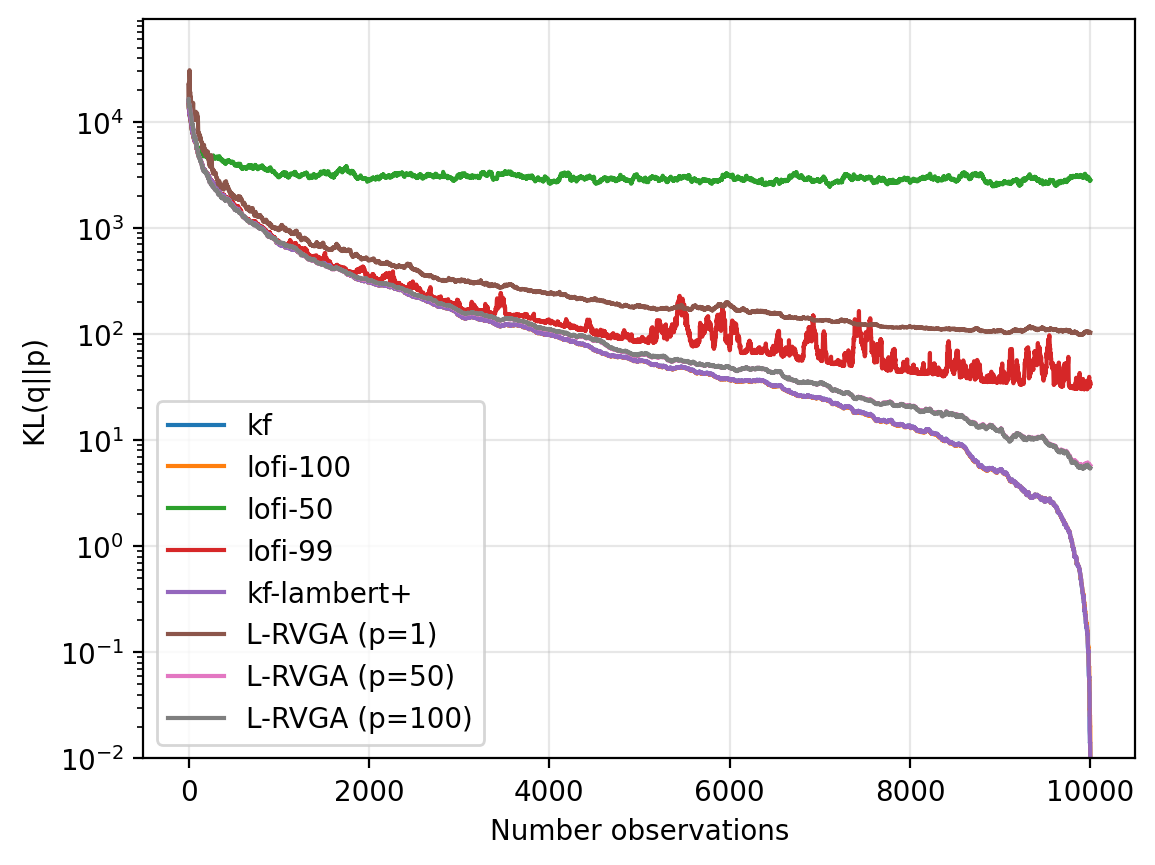

In [15]:
for label, res in hists.items():
    plt.plot(res["kl"], label=label)
    
plt.plot(data["ekf-divergence"]["full-kf"].ravel(), label="kf-lambert+")
plt.plot(data["ekf-divergence"]["p-1"].ravel(), label="L-RVGA (p=1)")
plt.plot(data["ekf-divergence"]["p-50"].ravel(), label="L-RVGA (p=50)")
plt.plot(data["ekf-divergence"]["p-100"].ravel(), label="L-RVGA (p=100)")
plt.legend()
plt.ylabel("KL(q||p)")
plt.yscale("log")
ymin, ymax = plt.ylim()
plt.ylim(10 ** -2, ymax)
plt.xlabel("Number observations")
plt.grid(alpha=0.3)

In [16]:
dist_true = tfd.MultivariateNormalFullCovariance(pmean, pcov)
dist_kf = tfd.MultivariateNormalFullCovariance(outputs["kf"].mean, outputs["kf"].cov)

tfd.kl_divergence(dist_kf, dist_true)

Array(7.632261e-06, dtype=float32)

In [17]:
dist_lofi = tfd.MultivariateNormalFullCovariance(outputs["lofi-100"].mean, outputs["lofi-100"].cov)
tfd.kl_divergence(dist_lofi, dist_true)

Array(0.01077911, dtype=float32)

In [18]:
tfd.kl_divergence(dist_kf, dist_lofi)

Array(0.01095176, dtype=float32)

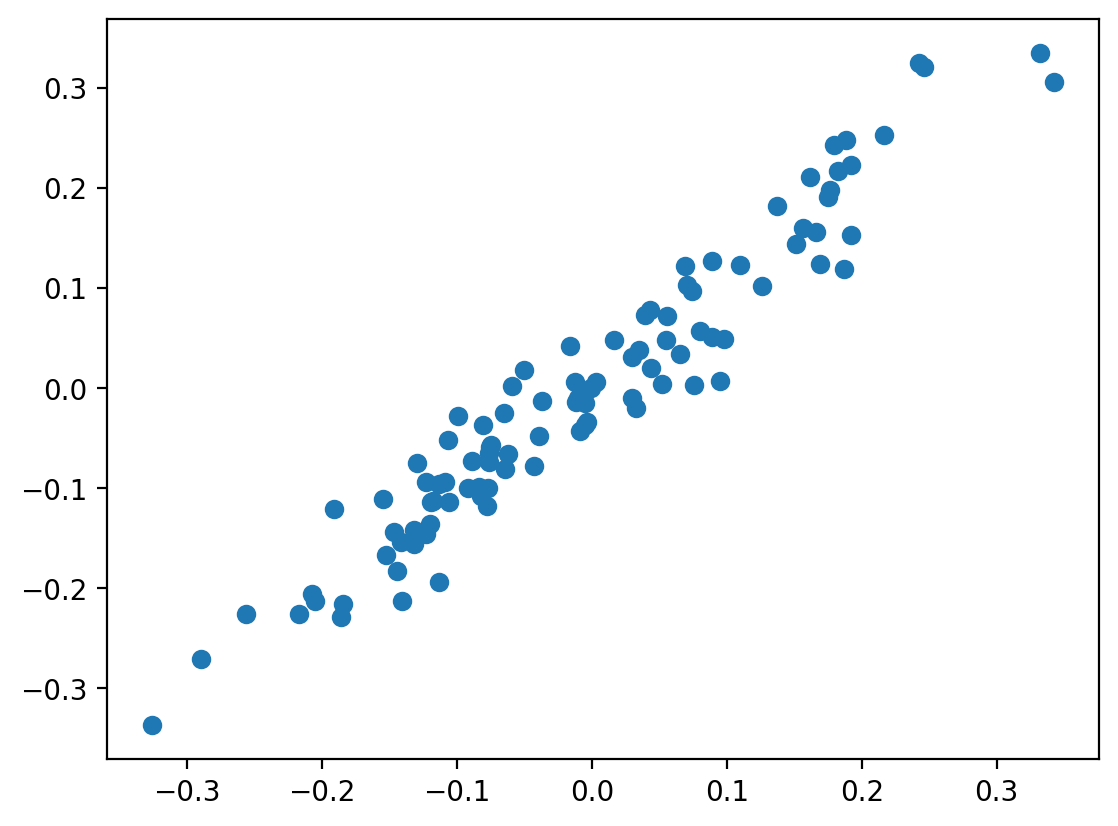

In [19]:
plt.scatter(outputs["kf"].mean, outputs["lofi-99"].mean)

## L-RVGA (Rebayes / Lambert)

In [20]:
dim_ranks = {
    10: "tab:red",
    20: "tab:blue",
    50: "tab:green",
    100: "tab:orange",
}

In [21]:
class LReg(nn.Module):
    activation: Callable = nn.elu
    
    def setup(self):
        self.mean = nn.Dense(1, use_bias=False)
    
    @nn.compact
    def __call__(self, x):
        """
        Link_fn: h(θ, x) = θ^T x
        """
        mean = self.mean(x)
        return mean

In [22]:
hparams = {
    "sigma2": 1.0,
    "eps": 1e-3 # 1e-8 gets rounded to 1.0
}

key = jax.random.PRNGKey(3141)
dim_rank = 50
std = 1.0
model = LReg()
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, data["X"], dim_rank, std, **hparams)
bel_init = bel_init.replace(mu=bel_init.mu * 0.0)

In [23]:
def fwd_link(mean, bel, x):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2

def log_prob(mean, bel, x, y):
    yhat, std = fwd_link(mean, bel, x)
    std = jnp.sqrt(std)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [24]:
estimator_lrvga = lrvga.LRVGA(fwd_link, log_prob, n_samples=30, n_outer=1, n_inner=3)

In [25]:
callback_kwargs = {"X_test": X_test, "y_test": y_test, "estimator": estimator_lrvga}

collection_hist_lrvga = {}
for dim_rank in dim_ranks:
    name_agent = f"lrvga-{dim_rank}"
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, data["X"], dim_rank, std, **hparams)
    bel_init = bel_init.replace(mu=bel_init.mu * 0.0)
    output, hist = estimator_lrvga.scan(
        data["X"], data["y"], callback=callback, bel=bel_init, **callback_kwargs
    )
    
    outputs[name_agent] = output
    hists[name_agent] = hist
    collection_hist_lrvga[dim_rank] = hist["kl"]

collection_hist_lrvga = jax.tree_map(np.array, collection_hist_lrvga)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

dim_rank=10
KL-Lambert 23.475
KL-Rebayes 20.066

dim_rank=20
KL-Lambert 14.574
KL-Rebayes 13.511

dim_rank=50
KL-Lambert 5.744
KL-Rebayes 5.618

dim_rank=100
KL-Lambert 5.438
KL-Rebayes 5.540



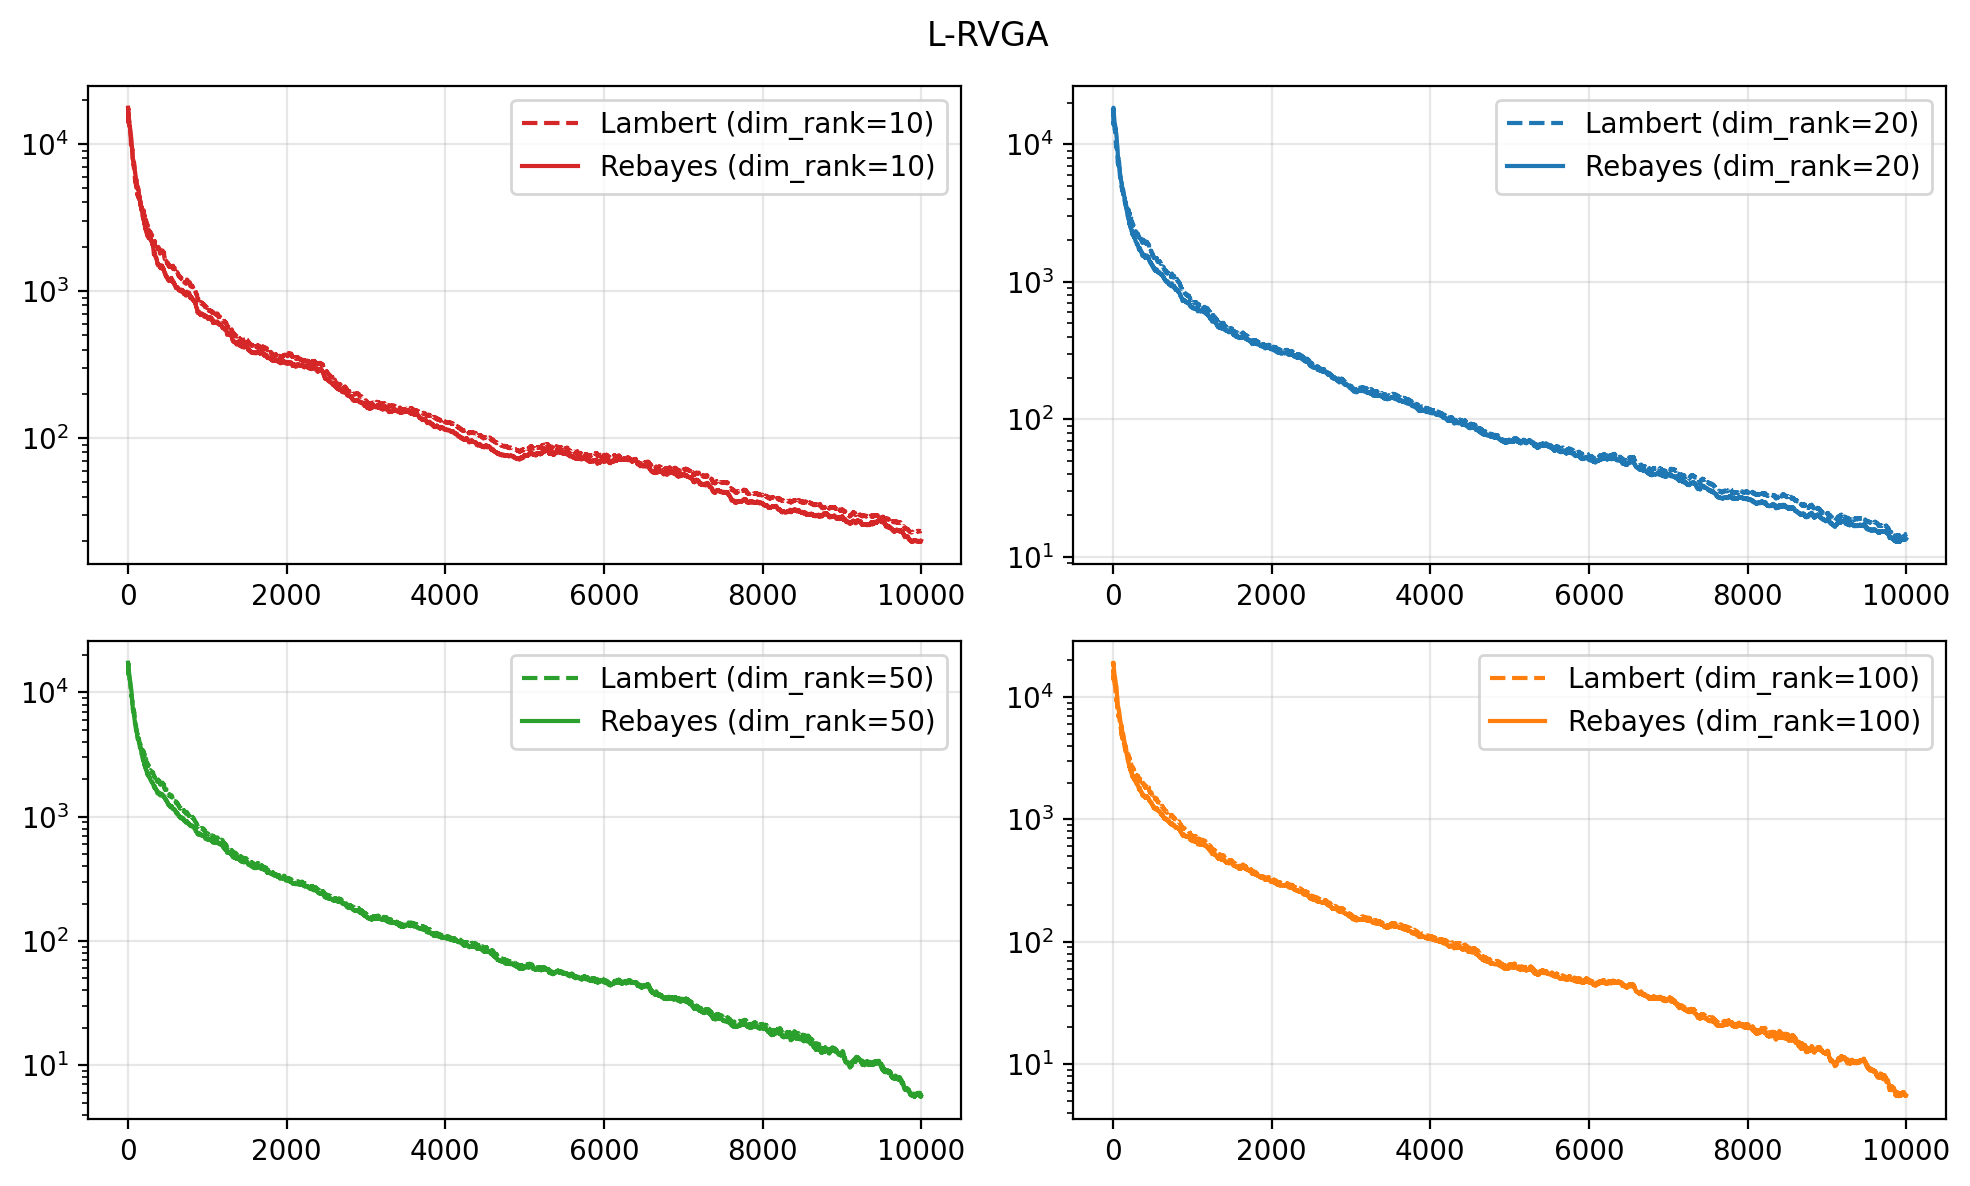

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()
for ax, dim_rank in zip(axs, dim_ranks):
    color = dim_ranks[dim_rank]
    kl_lambert = data["ekf-divergence"][f"p-{dim_rank}"].ravel()
    kl_rebayes = collection_hist_lrvga[dim_rank]
    ax.plot(kl_lambert, label=f"Lambert ({dim_rank=})", color=color, linestyle="--")
    ax.plot(kl_rebayes, label=f"Rebayes ({dim_rank=})", color=color)
    ax.legend()
    ax.set_yscale("log")
    ax.grid(alpha=0.3)
    
    kl_lambert_last = kl_lambert[-1].item()
    kl_rebayes_last = kl_rebayes[-1].item()
    print(f"{dim_rank=}")
    print(f"KL-Lambert {kl_lambert_last:0.3f}")
    print(f"KL-Rebayes {kl_rebayes_last:0.3f}", end="\n" * 2)
plt.suptitle("L-RVGA")
plt.tight_layout()

# RMSE

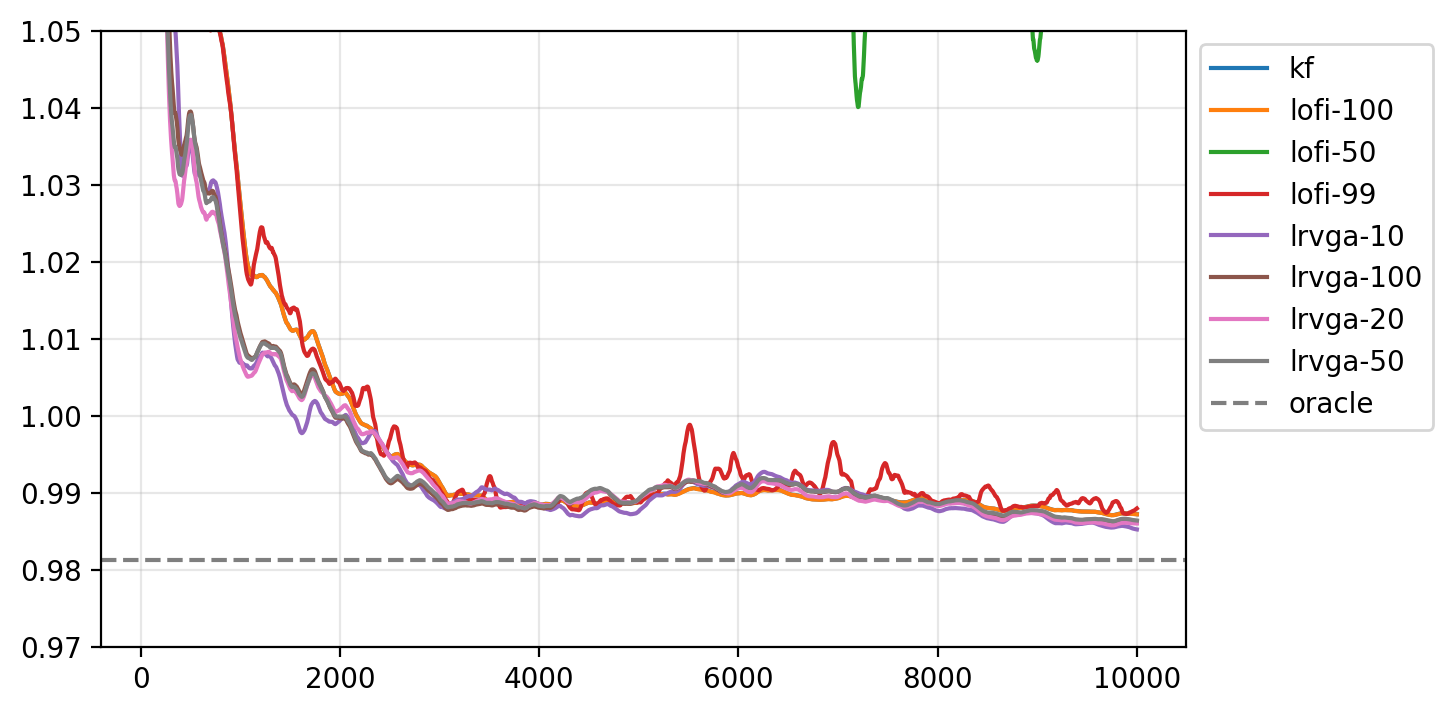

In [42]:
def rmse(phist):
    yhat_test = jnp.einsum("tm,km->tk", phist, X_test)
    err_hist = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean(axis=1))
    return err_hist

params_agents = get_subtree(hists, "mean")
rmse_hist_agents = jax.tree_map(rmse, params_agents)
rmse_hist_agents = jax.tree_map(np.array, rmse_hist_agents)
rmse_hist_agents = pd.DataFrame(rmse_hist_agents)

yhat_truep = jnp.einsum("m,nm->n", data["params_true"], X_test)
rmse_optimal = jnp.sqrt(jnp.power(yhat_truep - y_test, 2).mean().item())

fig, ax = plt.subplots(figsize=(7, 4))
rmse_hist_agents.rolling(100).mean().plot(ax=ax)
plt.axhline(y=rmse_optimal, c="tab:gray", linestyle="--", label="oracle")
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(0.97, 1.05)
plt.grid(alpha=0.3)

In [46]:
# RMSE on the train dataset
yhat_truep = jnp.einsum("m,nm->n", data["params_true"], data["X"])
rmse_optimal = jnp.sqrt(jnp.power(yhat_truep - data["y"], 2).mean().item())
rmse_optimal

Array(0.99883366, dtype=float32, weak_type=True)

## Eigenvalues

In [60]:
eigvals_agents = get_subtree(hists, "eigvals")
eigvals_agents = jax.tree_map(np.array, eigvals_agents)
xrange = np.arange(num_features)

CPU times: user 3min 12s, sys: 1.86 s, total: 3min 14s
Wall time: 3min 14s


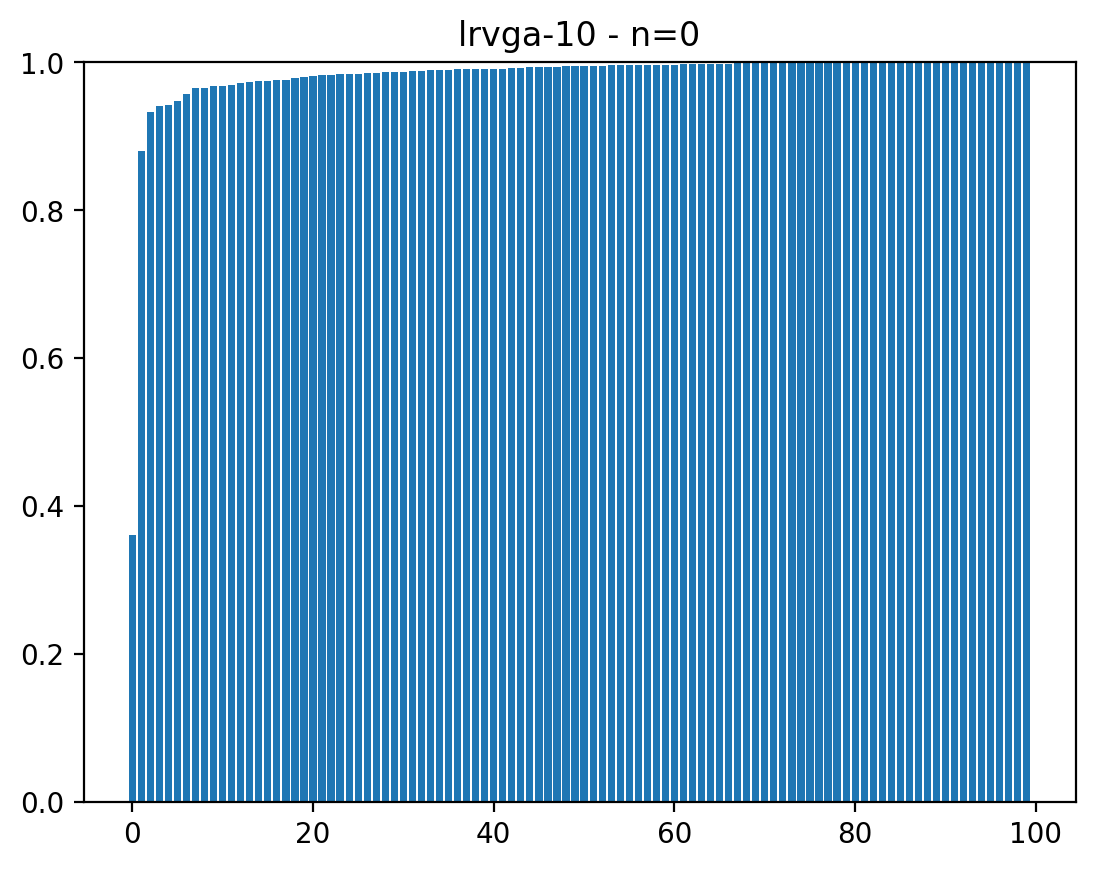

In [65]:
%%time
name_agent = "lrvga-10"
fig, ax = plt.subplots()
def animate(n):
    plt.cla()
    plt.bar(xrange, eigvals_agents[name_agent][n])
    plt.title(f"{name_agent} - {n=}")
    plt.ylim(0, 1.0)
    return ax

frames = np.arange(1_000)
anim = animation.FuncAnimation(fig, animate, frames=frames)
anim.save(f"eigenvalues-{name_agent}.mp4", dpi=100, bitrate=-1, fps=30)

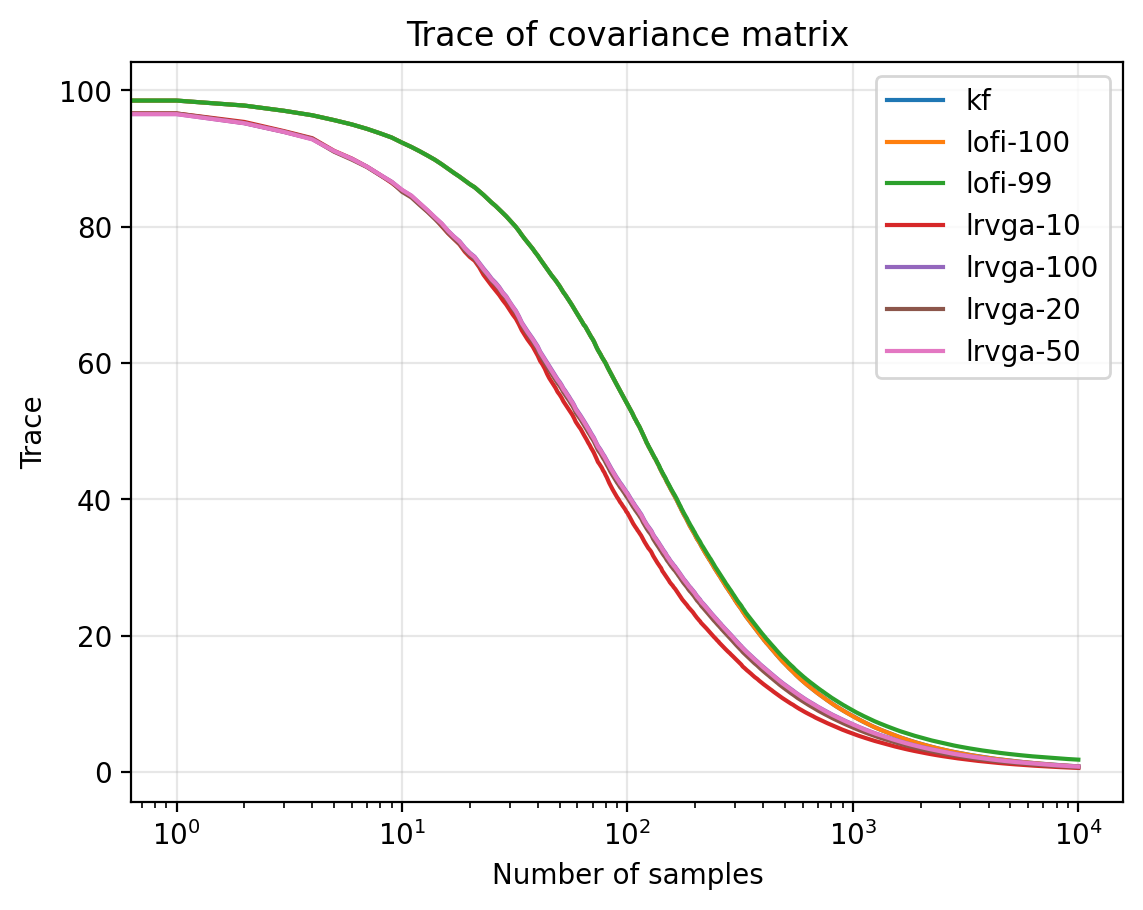

In [83]:
pd.DataFrame(jax.tree_map(lambda x: x.sum(axis=-1), eigvals_agents)).drop("lofi-50", axis=1).plot()
plt.title("Trace of covariance matrix")
plt.xscale("log")
plt.xlabel("Number of samples")
plt.ylabel("Trace")
plt.grid(alpha=0.3)